### Descripción del proyecto
Trabajas en la compañía de extracción de petróleo OilyGiant. Tu tarea es encontrar los mejores lugares donde abrir 200 pozos nuevos de petróleo.

Para completar esta tarea, tendrás que realizar los siguientes pasos:

Leer los archivos con los parámetros recogidos de pozos petrolíferos en la región seleccionada: calidad de crudo y volumen de reservas.
Crear un modelo para predecir el volumen de reservas en pozos nuevos.
Elegir los pozos petrolíferos que tienen los valores estimados más altos.
Elegir la región con el beneficio total más alto para los pozos petrolíferos seleccionados.
Tienes datos sobre muestras de crudo de tres regiones. Ya se conocen los parámetros de cada pozo petrolero de la región. Crea un modelo que ayude a elegir la región con el mayor margen de beneficio. Analiza los beneficios y riesgos potenciales utilizando la técnica bootstrapping.

#### Condiciones:
Solo se debe usar la regresión lineal para el entrenamiento del modelo.
Al explorar la región, se lleva a cabo un estudio de 500 puntos con la selección de los mejores 200 puntos para el cálculo del beneficio.
El presupuesto para el desarrollo de 200 pozos petroleros es de 100 millones de dólares.
Un barril de materias primas genera 4.5 USD de ingresos. El ingreso de una unidad de producto es de 4500 dólares (el volumen de reservas está expresado en miles de barriles).
Después de la evaluación de riesgo, mantén solo las regiones con riesgo de pérdidas inferior al 2.5%. De las que se ajustan a los criterios, se debe seleccionar la región con el beneficio promedio más alto.
Los datos son sintéticos: los detalles del contrato y las características del pozo no se publican.

#### Descripción de datos
Los datos de exploración geológica de las tres regiones se almacenan en archivos:

- geo_data_0.csv. Pozo 0
- geo_data_1.csv. Pozo 1
- geo_data_2.csv. Pozo 2

- id — identificador único de pozo de petróleo
- f0, f1, f2 — tres características de los puntos (su significado específico no es importante, pero las características en sí son significativas)
- product — volumen de reservas en el pozo de petróleo (miles de barriles).

In [1]:
# Importación de librerías estándar
import numpy as np  
import pandas as pd
import os
import sys
from typing import Optional

# Importación de bibliotecas para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Importación de funciones de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import missingno as msno

In [2]:
# Agregamos el archivo util_functions.py   //archivo personal con funciones utiles//
module_path = os.path.abspath(os.path.join('..', 'functions_RoCCO'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

# Importa la función missing_case_summary
from util_functions import *

#### Carga de Datos

In [3]:
#Cargamos los datos desde los archivos csv
geo_data_0 = pd.read_csv('../datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('../datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('../datasets/geo_data_2.csv')

In [4]:
# Resumen de 
missing_data_by_column(geo_data_0.drop('id',axis=1))

Estadísticas Globales:
- Valores ausentes totales: 0
- Porcentaje promedio de ausentes: 0.0%



,variable,n_missing,dtype,n_cases,complete_cases,pct_missing,n_unique_complete,max_value,min_value,std_dev,variance,median_value,mean_value,mode_value,q25,q75
0,f0,0,float64,100000,100000,0.0,100000,2.36,-1.41,0.87,0.76,0.50,0.50,-1.408605,-0.07,1.07
1,f1,0,float64,100000,100000,0.0,100000,1.34,-0.85,0.50,0.25,0.25,0.25,-0.848218,-0.20,0.70
2,f2,0,float64,100000,100000,0.0,100000,16.00,-12.09,3.25,10.55,2.52,2.50,-12.088328,0.29,4.72
3,product,0,float64,100000,100000,0.0,100000,185.36,0.00,44.29,1961.49,91.85,92.50,0.000000,56.50,128.56


In [5]:
# Revisamos los datos
geo_data_0.sample(10)

,id,f0,f1,f2,product
19596,EEVdU,0.403205,-0.224067,4.919017,85.970869
79029,4AYT2,0.492083,-0.200906,1.963742,24.295981
79195,Rg9Mp,0.155156,0.169021,6.087141,127.433842
29267,ttID0,0.290876,-0.030859,2.776896,179.644260
20714,gN8r8,2.029223,0.260956,8.156438,131.819706
56038,X5G7G,0.090228,0.428226,6.859143,88.106361
32029,gjfs2,1.708081,-0.052035,-6.315913,45.350935
37224,F4ePB,1.949876,0.082295,1.203397,156.616749
70030,2OcA8,0.888728,-0.553285,6.042208,30.304691
81634,887yR,-0.053682,0.006911,2.769635,25.830588


In [6]:
# Revisamos las caracteristicas de los datos
geo_data_0.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
# Revisamos si tenemos duplicados
geo_data_0.duplicated().value_counts() 

False    100000
Name: count, dtype: int64

In [8]:
# Revisamos los datos
missing_data_by_column(geo_data_1.drop('id',axis=1))

Estadísticas Globales:
- Valores ausentes totales: 0
- Porcentaje promedio de ausentes: 0.0%



,variable,n_missing,dtype,n_cases,complete_cases,pct_missing,n_unique_complete,max_value,min_value,std_dev,variance,median_value,mean_value,mode_value,q25,q75
0,f0,0,float64,100000,100000,0.0,100000,29.42,-31.61,8.97,80.39,1.15,1.14,-31.609576,-6.30,8.62
1,f1,0,float64,100000,100000,0.0,100000,18.73,-26.36,5.12,26.21,-4.81,-4.80,-26.358598,-8.27,-1.33
2,f2,0,float64,100000,100000,0.0,100000,5.02,-0.02,1.70,2.90,2.01,2.49,-0.018144,1.00,4.00
3,product,0,float64,100000,100000,0.0,12,137.95,0.00,45.94,2110.89,57.09,68.83,53.906522,26.95,107.81


In [9]:
# Revisamos las caracteristicas de los datos
geo_data_1.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
# Revisamos si tenemos duplicados
geo_data_1.duplicated().value_counts()

False    100000
Name: count, dtype: int64

In [11]:
# Revisamos los datos
missing_data_by_column(geo_data_2.drop('id',axis=1))

Estadísticas Globales:
- Valores ausentes totales: 0
- Porcentaje promedio de ausentes: 0.0%



,variable,n_missing,dtype,n_cases,complete_cases,pct_missing,n_unique_complete,max_value,min_value,std_dev,variance,median_value,mean_value,mode_value,q25,q75
0,f0,0,float64,100000,100000,0.0,100000,7.24,-8.76,1.73,3.00,0.01,0.0,-8.760004,-1.16,1.16
1,f1,0,float64,100000,100000,0.0,100000,7.84,-7.08,1.73,2.99,-0.01,-0.0,-7.084020,-1.17,1.16
2,f2,0,float64,100000,100000,0.0,100000,16.74,-11.97,3.47,12.06,2.48,2.5,-11.970335,0.13,4.86
3,product,0,float64,100000,100000,0.0,100000,190.03,0.00,44.75,2002.56,94.93,95.0,0.000000,59.45,130.60


In [12]:
# Revisamos las caracteristicas de los datos
geo_data_2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
# Revisamos si tenemos duplicados
geo_data_2.duplicated().value_counts()

False    100000
Name: count, dtype: int64

#### A continuacion entrenaremos y probaremos el modelo para cada región en este caso geo_data_0.csv:

In [14]:
#Valores maximos, minimosy promedio
geo_data_0.select_dtypes(float).agg(['max','min','average']).T

,max,min,average
f0,2.362331,-1.408605,0.500419
f1,1.343769,-0.848218,0.250143
f2,16.003790,-12.088328,2.502647
product,185.364347,0.000000,92.500000


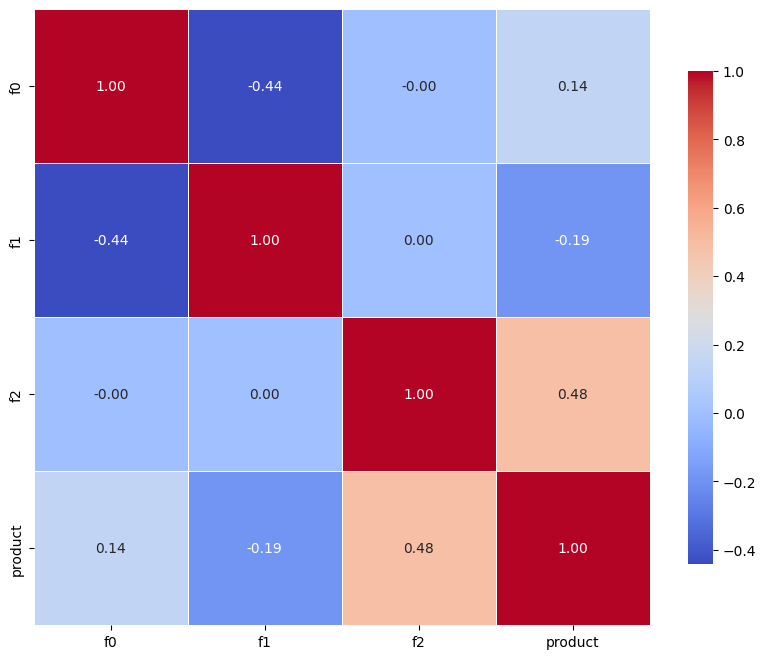

In [15]:
# Hacemos una matrix de correlaciones con seaborn para ver las relaciones entre las diferentes variables
data_0 = geo_data_0.drop('id',axis=1)
matrix_correlation(data_0)

#### Dividimos los datos en un conjunto de entrenamiento y un conjunto de validación en una proporción de 75:25

In [16]:
#Caracteristicas y objetivos para cada region

# Separamos las características y el objetivo
features_0 = data_0.drop('product', axis=1)  # Eliminamos la columna 'product' para obtener las características
target_0 = data_0['product']  # La columna 'product' es el objetivo

# Dividimos los datos en conjuntos de entrenamiento y validación (75% entrenamiento, 25% validación)
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=42
)

# Creamos y entrenamos el modelo de regresión lineal
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)

# Realizamos las predicciones sobre el conjunto de validación
predicted = model_0.predict(features_valid_0)

# Calculamos el RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(target_valid_0, predicted))
print(f"RMSE: {rmse:.2f}")

# Calculamos el R² (coeficiente de determinación)
r2 = r2_score(target_valid_0, predicted)
print(f"R²: {r2:.2f}")

# Calculamos el volumen medio de reservas predicho
volumen_medio_predicho = predicted.mean()
print(f'Volumen medio de reservas predicho: {volumen_medio_predicho:.2f}')


RMSE: 37.76
R²: 0.27
Volumen medio de reservas predicho: 92.40


#### Analizamos Resutados

Para geo_data_0:
- Obtenemos el valor promedio de las prediciones de las reservas,. un 92.4
- Obtuvimos un RMSE de 37.75, esto quiere decir que tenemos errores de hasta 37.75 entre los valores reales y los valores pronosticados por el modelo.

#### A continuacion entrenaremos y probaremos el modelo para cada región en este caso geo_data_1.csv:

In [17]:
#Valores maximos, minimosy promedio

geo_data_1.select_dtypes(float).agg(['max','min','average']).T

,max,min,average
f0,29.421755,-31.609576,1.141296
f1,18.734063,-26.358598,-4.796579
f2,5.019721,-0.018144,2.494541
product,137.945408,0.000000,68.825000


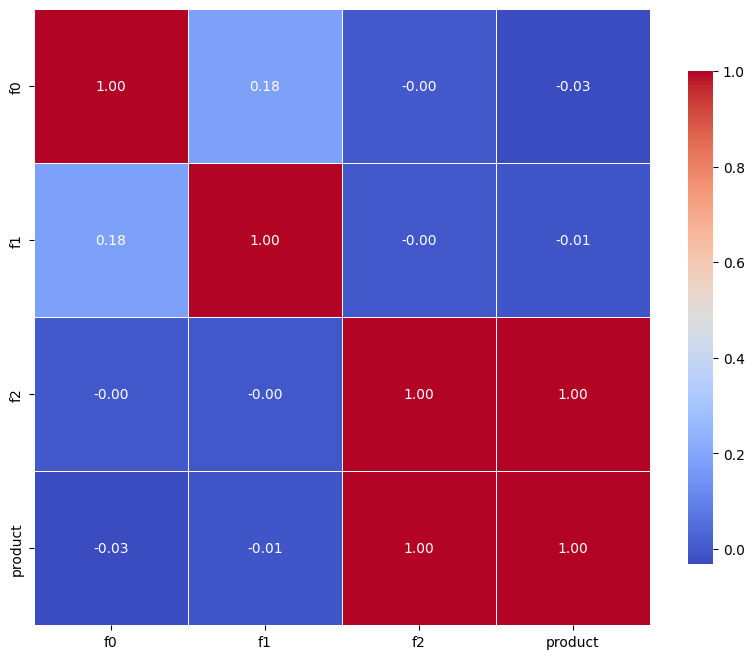

In [18]:
# Hacemos una matrix de correlaciones con seaborn para ver las relaciones entre las diferentes variables
data_1 = geo_data_1.drop('id', axis=1)
matrix_correlation(data_1)

In [19]:
#Caracteristicas y objetivos para cada region

# Separamos las características y el objetivo
features_1 = data_1.drop('product', axis=1)  # Eliminamos la columna 'product' para obtener las características
target_1 = data_1['product']  # La columna 'product' es el objetivo

# Dividimos los datos en conjuntos de entrenamiento y validación (75% entrenamiento, 25% validación)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=42
)

# Creamos y entrenamos el modelo de regresión lineal
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)

# Realizamos las predicciones sobre el conjunto de validación
predicted = model_1.predict(features_valid_1)

# Calculamos el RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(target_valid_1, predicted))
print(f"RMSE: {rmse:.2f}")

# Calculamos el R² (coeficiente de determinación)
r2 = r2_score(target_valid_1, predicted)
print(f"R²: {r2:.2f}")

# Calculamos el volumen medio de reservas predicho
volumen_medio_predicho = predicted.mean()
print(f'Volumen medio de reservas predicho: {volumen_medio_predicho:.2f}')


RMSE: 0.89
R²: 1.00
Volumen medio de reservas predicho: 68.71


Para geo_data_1
- Obtenemos el valor promedio de las prediciones de las reservas, un 68.71
- Obtuvimos un RMSE de 0.89, esto quiere decir que tenemos errores de hasta 0.89 entre los valores reales y los valores pronosticados por el modelo. Es un buen valor quiere decir que nuestra prediccion esta muy cerca de los valores reales.

#### A continuacion entrenaremos y probaremos el modelo para cada región en este caso geo_data_2.csv:

In [20]:
#Valores maximos, minimosy promedio

geo_data_2.select_dtypes(float).agg(['max','min','average']).T

,max,min,average
f0,7.238262,-8.760004,0.002023
f1,7.844801,-7.084020,-0.002081
f2,16.739402,-11.970335,2.495128
product,190.029838,0.000000,95.000000


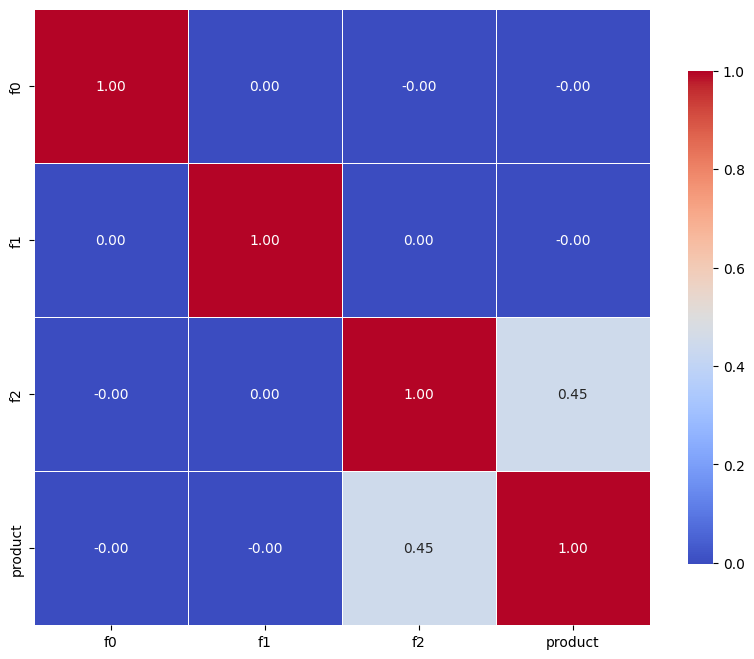

In [21]:
# Hacemos una matrix de correlaciones con seaborn para ver las relaciones entre las diferentes variables
data_2 = geo_data_2.drop('id', axis=1)
matrix_correlation(data_2)

In [22]:
#Caracteristicas y objetivos para cada region

# Separamos las características y el objetivo
features_2 = data_2.drop('product', axis=1)  # Eliminamos la columna 'product' para obtener las características
target_2 = data_2['product']  # La columna 'product' es el objetivo

# Dividimos los datos en conjuntos de entrenamiento y validación (75% entrenamiento, 25% validación)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=42
)

# Creamos y entrenamos el modelo de regresión lineal
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)

# Realizamos las predicciones sobre el conjunto de validación
predicted = model_2.predict(features_valid_2)

# Calculamos el RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(target_valid_2, predicted))
print(f"RMSE: {rmse:.2f}")

# Calculamos el R² (coeficiente de determinación)
r2 = r2_score(target_valid_2, predicted)
print(f"R²: {r2:.2f}")

# Calculamos el volumen medio de reservas predicho
volumen_medio_predicho = predicted.mean()
print(f'Volumen medio de reservas predicho: {volumen_medio_predicho:.2f}')


RMSE: 40.15
R²: 0.20
Volumen medio de reservas predicho: 94.77


Para geo_data_2
- Obtenemos el valor promedio de las prediciones de las reservas, un 94.77
- Obtuvimos un RMSE de 40.15, esto quiere decir que tenemos errores de hasta 40.15 entre los valores reales y los valores pronosticados por el modelo.

### Cálculo de ganancias:

In [23]:
# Calculamos todos los valores pronosticados de features y hacemos dataframe con los valores de target

target_predicted_0 = pd.DataFrame({'product_predicted': model_0.predict(features_0), 'product':target_0} )

target_predicted_1 = pd.DataFrame({'product_predicted': model_1.predict(features_1), 'product':target_1} )

target_predicted_2 = pd.DataFrame({'product_predicted': model_2.predict(features_2), 'product':target_2} )

#### Dada la inversión de 100 millones por 200 pozos petrolíferos, de media un pozo petrolífero debe producir al menos un valor de 500,000 dólares en unidades para evitar pérdidas (esto es equivalente a 111.1 unidades). Compararemos esta cantidad con la cantidad media de reservas en cada región. 

In [24]:
# Datos apartir del glosario
investment = 100000000  # 100 millones
wells = 200
cost_per_well = investment / wells  # Cost_per_unit
min_profit_per_well = 111.1  # Valor necesario para evitar pérdidas

#### Comentarios sobre el calculo de beneficios
- Tenemos los modelos para cada conjunto de datos.
- Podemos calcular las reservas, los beneficio y la ganacia para cada uno
- Podemos comparar la media de reservas por cada pozo para ver si tendremos perdidas

#### Eligimos los 200 pozos con los valores de predicción más altos de cada una de las 3 regiones (es decir, archivos 'csv').

In [25]:
# geo_data_0 calculos valores pronosticados por el modelo
# top 200
pred_0_top_200 = target_predicted_0.sort_values('product_predicted', ascending=False)[:200]
print(f'Maximo : {round(pred_0_top_200['product_predicted'].max(),2)} miles de barriles y Minimo: {round(pred_0_top_200['product_predicted'].min(),2)} miles de barriles')


Maximo : 195.1 miles de barriles y Minimo: 157.18 miles de barriles


In [26]:
# geo_data_1 calculos valores pronosticados por el modelo
# top 200
pred_1_top_200 = target_predicted_1.sort_values('product_predicted', ascending=False)[:200]
print(f'Maximo : {round(pred_1_top_200['product_predicted'].max(),2)} miles de barriles y Minimo: {round(pred_1_top_200['product_predicted'].min(),2)} miles de barriles')


Maximo : 140.36 miles de barriles y Minimo: 138.9 miles de barriles


In [27]:
# geo_data_2 calculos valores pronosticados por el modelo
# top 200
pred_2_top_200 = target_predicted_2.sort_values('product_predicted', ascending=False)[:200]
print(f'Maximo : {round(pred_2_top_200['product_predicted'].max(),2)} miles de barriles y Minimo: {round(pred_2_top_200['product_predicted'].min(),2)} miles de barriles')

Maximo : 176.98 miles de barriles y Minimo: 151.42 miles de barriles


#### 4.2 Resume el volumen objetivo de reservas según dichas predicciones. Almacena las predicciones para los 200 pozos para cada una de las 3 regiones.

In [28]:

# Función para calcular reservas totales y promedio

def calcular_reservas(geo_name, top_200, min_profit_per_well):
    """
    Calcula y muestra las reservas promedio y totales, además de evaluar la ganancia.

    Parámetros:
    - geo_name (str): Nombre del conjunto de datos o región.
    - top_200 (DataFrame): Conjunto de datos con los pozos seleccionados.
    - min_profit_per_well (float): Mínimo beneficio por pozo en miles de barriles para evitar pérdidas.

    """
    print(f'Conjunto de datos: {geo_name}')
    
    # Cálculo de reservas promedio
    prom_reserves = top_200['product'].mean()
    print(f'Reserva Promedio por Pozo (mínimo: {min_profit_per_well} miles de barriles): {round(prom_reserves, 2)}')
    
    # Cálculo de reservas totales
    total_reserves = top_200['product'].sum()
    print(f'Reserva Total: {round(total_reserves, 2)} miles de barriles')

In [29]:
# Para los pozos de la region geo_data_0:
calcular_reservas('Geo_data_0',pred_0_top_200, min_profit_per_well)

Conjunto de datos: Geo_data_0
Reserva Promedio por Pozo (mínimo: 111.1 miles de barriles): 150.28
Reserva Total: 30055.95 miles de barriles


In [30]:
# Para los pozos de la region geo_data_1:
calcular_reservas('Geo_data_1',pred_1_top_200, min_profit_per_well)

Conjunto de datos: Geo_data_1
Reserva Promedio por Pozo (mínimo: 111.1 miles de barriles): 137.95
Reserva Total: 27589.08 miles de barriles


In [31]:
# Para los pozos de la region geo_data_2:
calcular_reservas('Geo_data_2',pred_2_top_200, min_profit_per_well)

Conjunto de datos: Geo_data_2
Reserva Promedio por Pozo (mínimo: 111.1 miles de barriles): 139.96
Reserva Total: 27991.05 miles de barriles


#### Calcularemos la ganancia potencial de los 200 pozos principales por región.

In [32]:
# Para los pozos de la región geo_data_0:

print('Conjunto de datos: Geo Data 0')

# Calculamos las reservas totales (en miles de barriles)
total_reserves = pred_0_top_200['product'].sum()

# Cálculo del beneficio total en dólares
# Dato: 111.1 miles de barriles equivale a $500,000 (esto nos da una tasa de conversión).
# El cálculo toma el total de las reservas y lo multiplica por la tasa de beneficio por barril.
revenue_per_well = cost_per_well / min_profit_per_well  # Cálculo del beneficio por barril
revenue = total_reserves * revenue_per_well  # Beneficio total

# Mostramos el beneficio total con formato adecuado (con miles de separadores y 2 decimales)
print(f'Beneficio Total: ${revenue:,.2f} dólares')

# Calculamos la ganancia neta, restando la inversión inicial
profit = revenue - investment

# Mostramos la ganancia neta con formato adecuado
print(f'Ganancia: ${profit:,.2f} dólares')

# Almacenamos los resultados en un diccionario para su uso posterior
geo_0 = {
    'Reserva_Total': total_reserves,  # Reservas totales en miles de barriles
    'Beneficio_Total': revenue,  # Beneficio total en dólares
    'Ganancia': profit  # Ganancia neta en dólares
}

Conjunto de datos: Geo Data 0
Beneficio Total: $135,265,281.57 dólares
Ganancia: $35,265,281.57 dólares


In [33]:
# Para los pozos de la región geo_data_1:

print('Conjunto de datos: Geo Data 1')

# Calculamos las reservas totales (en miles de barriles)
total_reserves = pred_1_top_200['product'].sum()

# Cálculo del beneficio total en dólares
# Dato: 111.1 miles de barriles equivale a $500,000 (esto nos da una tasa de conversión).
# El cálculo toma el total de las reservas y lo multiplica por la tasa de beneficio por barril.
revenue_per_well = cost_per_well / min_profit_per_well  # Cálculo del beneficio por barril
revenue = total_reserves * revenue_per_well  # Beneficio total

# Mostramos el beneficio total con formato adecuado (con miles de separadores y 2 decimales)
print(f'Beneficio Total: ${revenue:,.2f} dólares')

# Calculamos la ganancia neta, restando la inversión inicial
profit = revenue - investment

# Mostramos la ganancia neta con formato adecuado
print(f'Ganancia: ${profit:,.2f} dólares')

# Almacenamos los resultados en un diccionario para su uso posterior
geo_1 = {
    'Reserva_Total': total_reserves,  # Reservas totales en miles de barriles
    'Beneficio_Total': revenue,  # Beneficio total en dólares
    'Ganancia': profit  # Ganancia neta en dólares
}

Conjunto de datos: Geo Data 1
Beneficio Total: $124,163,283.30 dólares
Ganancia: $24,163,283.30 dólares


In [34]:
# Para los pozos de la región geo_data_2:

print('Conjunto de datos: Geo Data 2')

# Calculamos las reservas totales (en miles de barriles)
total_reserves = pred_2_top_200['product'].sum()

# Cálculo del beneficio total en dólares
# Dato: 111.1 miles de barriles equivale a $500,000 (esto nos da una tasa de conversión).
# El cálculo toma el total de las reservas y lo multiplica por la tasa de beneficio por barril.
revenue_per_well = cost_per_well / min_profit_per_well  # Cálculo del beneficio por barril
revenue = total_reserves * revenue_per_well  # Beneficio total

# Mostrar el beneficio total con formato adecuado (con miles de separadores y 2 decimales)
print(f'Beneficio Total: ${revenue:,.2f} dólares')

# Calculamos la ganancia neta, restando la inversión inicial
profit = revenue - investment

# Mostrar la ganancia neta con formato adecuado
print(f'Ganancia: ${profit:,.2f} dólares')

# Almacenamos los resultados en un diccionario para su uso posterior
geo_2 = {
    'Reserva_Total': total_reserves,  # Reservas totales en miles de barriles
    'Beneficio_Total': revenue,  # Beneficio total en dólares
    'Ganancia': profit  # Ganancia neta en dólares
}

Conjunto de datos: Geo Data 2
Beneficio Total: $125,972,337.17 dólares
Ganancia: $25,972,337.17 dólares


     Conjunto  Reserva_Total  Beneficio_Total      Ganancia
0  geo_data_0   30055.945566     1.352653e+08  3.526528e+07
1  geo_data_1   27589.081548     1.241633e+08  2.416328e+07
2  geo_data_2   27991.053319     1.259723e+08  2.597234e+07


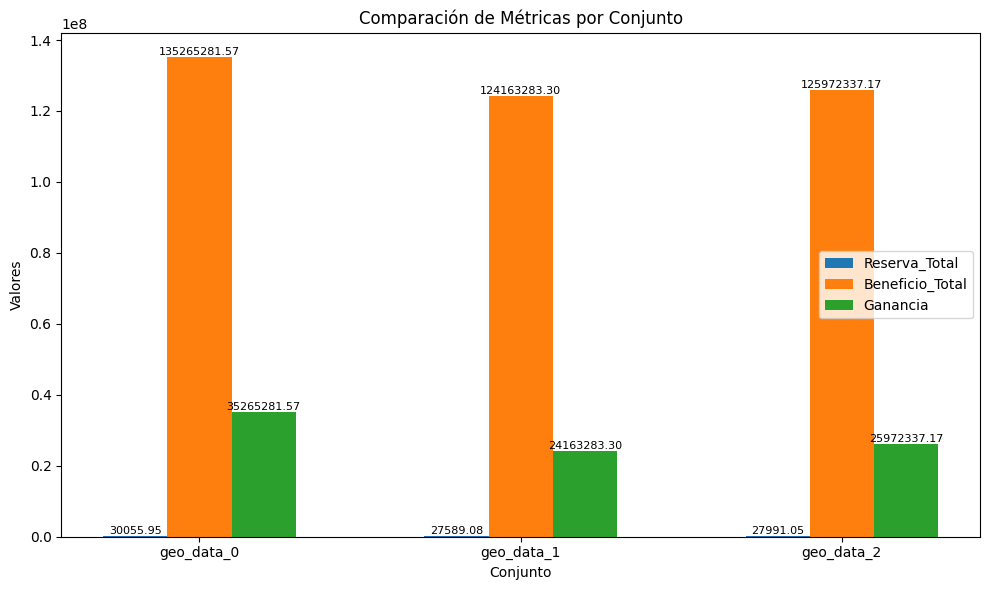

In [35]:

# Creamos el DataFrame a partir de los diccionarios
resultados = pd.DataFrame({
    'geo_data_0': geo_0,
    'geo_data_1': geo_1,
    'geo_data_2': geo_2
})

# Transponemos el DataFrame y restablecemos el índice
resultados = resultados.T.reset_index().rename(columns={'index': 'Conjunto'})

# Mostramos el DataFrame resultante
print(resultados)

# Definimos las métricas a graficar
metrics = ['Reserva_Total', 'Beneficio_Total', 'Ganancia']
n_groups = len(resultados)
bar_width = 0.2
indices = np.arange(n_groups)

# Creamos la figura y los ejes para el gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(10, 6))

# Iteramos sobre cada métrica para graficar sus barras y añadir las etiquetas
for i, metric in enumerate(metrics):
    bars = ax.bar(indices + i * bar_width, resultados[metric], bar_width, label=metric)
    # Agregar el valor numérico encima de cada barra
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

# Configuración de etiquetas y leyenda
ax.set_xlabel('Conjunto')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Métricas por Conjunto')
ax.set_xticks(indices + bar_width)
ax.set_xticklabels(resultados['Conjunto'])
ax.legend()

plt.tight_layout()
plt.show()


Conclusiones:
- Como podemos ver el conjunto de datos geo_data_0 es la que tiene mayores reservas, mayor beneficio y por consecuencia mayores ganancias. 

#### Calculo de riesgos y ganancias para cada región:
Empleremos la técnica del bootstrapping con 1000 muestras para hallar la distribución de los beneficios.

In [36]:
def bootstrap_profit(predictions, valids, cost=500000, min_profit_per_well=111.1, n_samples=1000, wells=500, price_per_barrel=4500, initial_investment=100_000_000):
    """
    Calcula la ganancia utilizando bootstrapping a partir de las predicciones de reservas de pozos.

    Parámetros:
    - predictions (pd.Series): Predicciones de reservas para los pozos (en miles de barriles).
    - valids (pd.Series): Reservas reales o validadas (en miles de barriles).
    - cost (float): Costo por pozo en dólares (por defecto 500,000).
    - min_profit_per_well (float): Mínimo beneficio por pozo en miles de barriles.
    - n_samples (int): Número de muestras de bootstrapping a realizar.
    - wells (int): Número de pozos a muestrear en cada muestra.
    - price_per_barrel (float): Precio por barril (por defecto 4500).
    - initial_investment (float): Inversión inicial (por defecto 100 millones).

    Retorna:
    - mean_profit (float): Ganancia promedio de las muestras de bootstrapping.
    - profits (np.array): Array con las ganancias para cada muestra.
    """
    
    # Verificar que las entradas sean series de Pandas
    if not isinstance(predictions, pd.Series) or not isinstance(valids, pd.Series):
        raise ValueError("Las predicciones y los valores válidos deben ser Series de Pandas.")

    # Inicializar la lista de beneficios
    profits = []

    # Realizamos el bootstrapping
    for _ in range(n_samples):
        # Tomamos una muestra aleatoria de 'wells' pozos con reemplazo, ordenada por las predicciones
        sample = predictions.sample(n=wells, replace=True).sort_values(ascending=False)[:200]
        
        # Calculamos el beneficio, multiplicando por el precio por barril y restando la inversión
        revenue = valids.loc[sample.index].sum() * price_per_barrel  # Ingresos de los pozos seleccionados
        profit = revenue - initial_investment  # Restamos la inversión inicial
        profits.append(profit)  # Añadimos el beneficio a la lista
    
    # Convertir la lista de ganancias a un array de numpy para facilitar estadísticas adicionales
    profits = np.array(profits)

    # Calcular la ganancia promedio de todas las muestras
    mean_profit = profits.mean()

    # Retornamos la ganancia promedio y las ganancias de cada muestra
    return mean_profit, profits


In [37]:
#geo_data_0
predicted_valid_0 = pd.DataFrame({'predicted':model_0.predict(features_valid_0),'valid':target_valid_0}) # 25K

mean_profit_0, profit_distribution_0 = bootstrap_profit(predicted_valid_0['predicted'], predicted_valid_0['valid'])
print('Para: geo_data_0')
print(f'Beneficio promedio para la región 0: ${mean_profit_0:,.2f} dolares')

Para: geo_data_0
Beneficio promedio para la región 0: $3,990,053.64 dolares


In [38]:
#geo_data_1
predicted_valid_1 = pd.DataFrame({'predicted':model_1.predict(features_valid_1),'valid':target_valid_1}) # 25K

mean_profit_1, profit_distribution_1 = bootstrap_profit(predicted_valid_1['predicted'], predicted_valid_1['valid'])
print('Para: geo_data_1')
print(f'Beneficio promedio para la región 1: ${mean_profit_1:,.2f} dolares')


Para: geo_data_1
Beneficio promedio para la región 1: $4,436,310.14 dolares


In [39]:
#geo_data_2
predicted_valid_2 = pd.DataFrame({'predicted':model_2.predict(features_valid_2),'valid':target_valid_2}) # 25K

mean_profit_2, profit_distribution_2 = bootstrap_profit(predicted_valid_2['predicted'], predicted_valid_2['valid'])
print('Para: geo_data_2')
print(f'Beneficio promedio para la región 2: ${mean_profit_2:,.2f} dolares')

Para: geo_data_2
Beneficio promedio para la región 2: $3,703,119.57 dolares


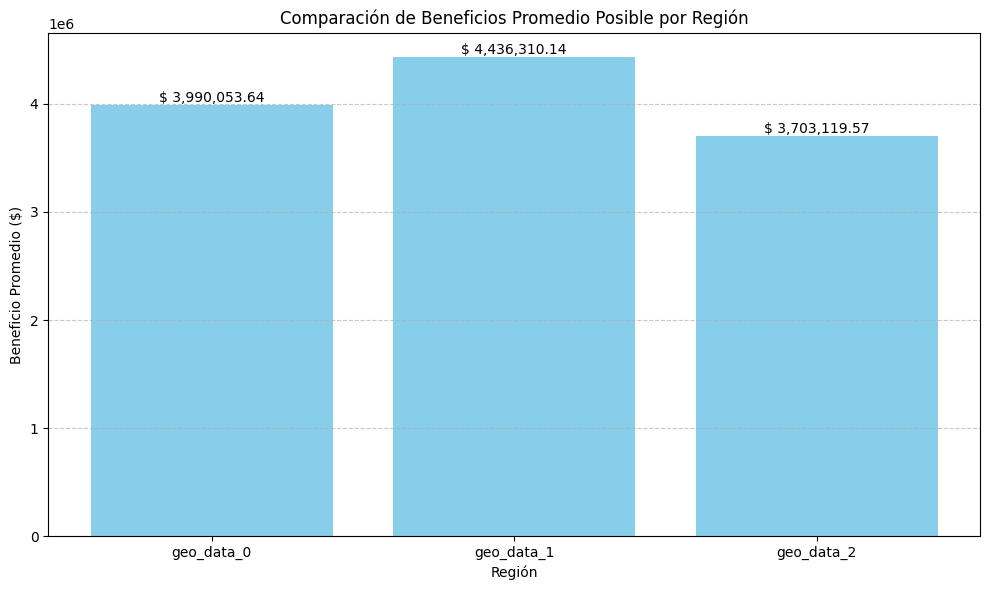

In [40]:
# Comparacion de Beneficios
region_scores = {
    'geo_data_0': {'mean_profit': mean_profit_0},
    'geo_data_1': {'mean_profit': mean_profit_1},
    'geo_data_2': {'mean_profit': mean_profit_2}
}

# Convertir el diccionario en un DataFrame
df_region_scores = pd.DataFrame.from_dict(region_scores, orient='index').reset_index().rename(columns={'index': 'Región'})

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(df_region_scores['Región'], df_region_scores['mean_profit'], color='skyblue')

# Añadir la etiqueta numérica encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'$ {height:,.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Región')
plt.ylabel('Beneficio Promedio ($)')
plt.title('Comparación de Beneficios Promedio Posible por Región')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


##### Buscaremos el beneficio promedio, el intervalo de confianza del 95% y el riesgo de pérdidas. La pérdida es una ganancia negativa, la calcúlaremos como una probabilidad en porcentajes.

In [41]:
def analyze_bootstrap_results(profit_distribution, confidence_level=95):
    # Calcula el intervalo de confianza
    lower_bound = np.percentile(profit_distribution, (100 - confidence_level) / 2) # limite inferior [2.5 
    upper_bound = np.percentile(profit_distribution, 100 - (100 - confidence_level) / 2) #limite superior  97.5]
    
    # Calcula la probabilidad de pérdida (ganancias negativas)
    risk_of_loss = (profit_distribution < 0).mean() * 100
    
    # Retorna el intervalo de confianza y el riesgo
    return lower_bound, upper_bound, risk_of_loss

In [42]:
# Analizamos resultados para la región 0
lower_bound_0, upper_bound_0, risk_of_loss_0 = analyze_bootstrap_results(profit_distribution_0)

print(f'Intervalo de confianza del 95% para la región 0: ${lower_bound_0:,.2f} dolares - ${upper_bound_0:,.2f} dolares')
print(f'Riesgo de pérdidas para la región 0: {risk_of_loss_0}%')

# Analizamos resultados para la región 1
lower_bound_1, upper_bound_1, risk_of_loss_1 = analyze_bootstrap_results(profit_distribution_1)

print(f'Intervalo de confianza del 95% para la región 1: ${lower_bound_1:,.2f} dolares - ${upper_bound_1:,.2f} dolares')
print(f'Riesgo de pérdidas para la región 1: {risk_of_loss_1}%')

# Analizamos resultados para la región 2
lower_bound_2, upper_bound_2, risk_of_loss_2 = analyze_bootstrap_results(profit_distribution_2)

print(f'Intervalo de confianza del 95% para la región 2:  ${lower_bound_2:,.2f} dolares - ${upper_bound_2:,.2f} dolares')
print(f'Riesgo de pérdidas para la región 2: {risk_of_loss_2}%')

Intervalo de confianza del 95% para la región 0: $-1,335,858.30 dolares - $8,806,768.80 dolares
Riesgo de pérdidas para la región 0: 6.4%
Intervalo de confianza del 95% para la región 1: $445,079.96 dolares - $8,580,398.28 dolares
Riesgo de pérdidas para la región 1: 1.2%
Intervalo de confianza del 95% para la región 2:  $-1,421,772.78 dolares - $9,049,861.75 dolares
Riesgo de pérdidas para la región 2: 8.3%


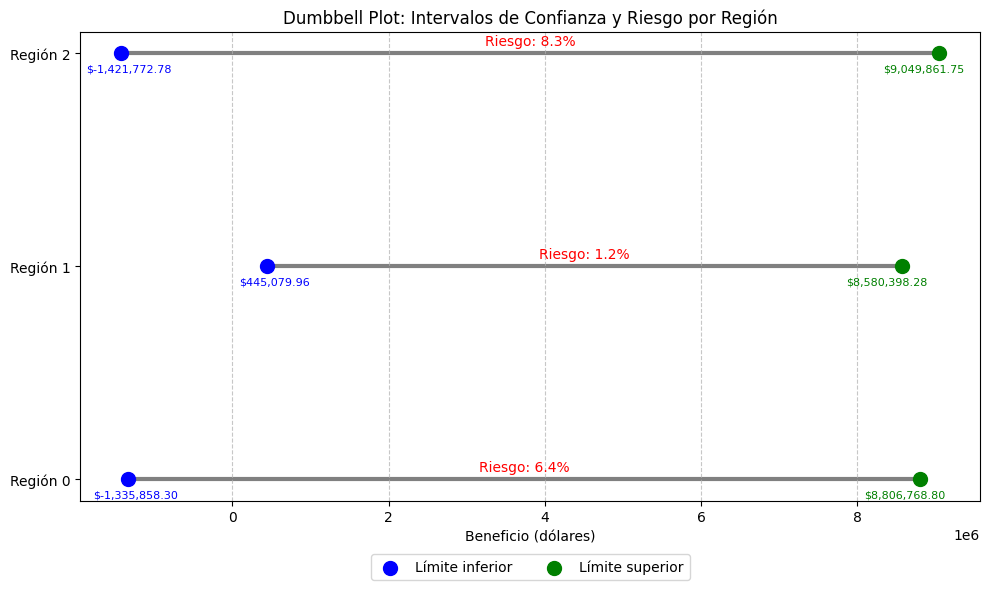

In [43]:
# Datos de ejemplo
regions = ['Región 0', 'Región 1', 'Región 2']
ci_lower = np.array([lower_bound_0, lower_bound_1, lower_bound_2])
ci_upper = np.array([upper_bound_0, upper_bound_1, upper_bound_2])
risk = np.array([risk_of_loss_0, risk_of_loss_1, risk_of_loss_2])

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(regions))

for i in range(len(regions)):
    # Dibuja la "mancuerna" (línea entre los dos extremos)
    ax.plot([ci_lower[i], ci_upper[i]], [y_pos[i], y_pos[i]], color='gray', linewidth=3, zorder=1)
    # Dibuja los extremos
    ax.scatter(ci_lower[i], y_pos[i], color='blue', s=100, zorder=2, label='Límite inferior' if i == 0 else "")
    ax.scatter(ci_upper[i], y_pos[i], color='green', s=100, zorder=2, label='Límite superior' if i == 0 else "")
    # Anota el riesgo de pérdidas en el centro del intervalo
    mid = (ci_lower[i] + ci_upper[i]) / 2
    ax.text(mid, y_pos[i] + 0.025, f'Riesgo: {risk[i]}%', ha='center', va='bottom', color='red', fontsize=10)
    # Opcional: anotar los valores de los extremos
    ax.text(ci_lower[i] + 0.1e6, y_pos[i] - 0.05, f'${ci_lower[i]:,.2f}', ha='center', va='top', color='blue', fontsize=8)
    ax.text(ci_upper[i] - 0.2e6, y_pos[i] - 0.05, f'${ci_upper[i]:,.2f}', ha='center', va='top', color='green', fontsize=8)

ax.set_yticks(y_pos)
ax.set_yticklabels(regions)
ax.set_xlabel('Beneficio (dólares)')
ax.set_title('Dumbbell Plot: Intervalos de Confianza y Riesgo por Región')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Propondremos una región para el desarrollo de pozos petrolíferos y justifica tu elección.

In [44]:
# Elegiremos la región con mejores resultados según beneficio y riesgo
region_scores = {
    0: {'mean_profit': mean_profit_0, 'risk': risk_of_loss_0},
    1: {'mean_profit': mean_profit_1, 'risk': risk_of_loss_1},
    2: {'mean_profit': mean_profit_2, 'risk': risk_of_loss_2}
}

# Inicializamos la mejor región
best_region = None

# Definimos la mejor región considerando el beneficio y el riesgo
for region, scores in region_scores.items():
    if best_region is None:
        best_region = region
    else:
        if (scores['mean_profit'] > region_scores[best_region]['mean_profit']) or (
            scores['mean_profit'] == region_scores[best_region]['mean_profit'] and scores['risk'] <= region_scores[best_region]['risk']):
            best_region = region

# Resultados
print(f"La mejor región para el desarrollo de pozos petrolíferos según el riesgo es la región {best_region}")
print(f"Reservas totales de la región {best_region}: {round(resultados.loc[best_region, 'Reserva_Total'], 2)} miles de barriles")
print(f"Beneficio total de la región {best_region}: ${resultados.loc[best_region, 'Beneficio_Total']:,.2f} dólares")
print(f"Ganancia de la región {best_region}: ${resultados.loc[best_region, 'Ganancia']:,.2f} dólares")


La mejor región para el desarrollo de pozos petrolíferos según el riesgo es la región 1
Reservas totales de la región 1: 27589.08 miles de barriles
Beneficio total de la región 1: $124,163,283.30 dólares
Ganancia de la región 1: $24,163,283.30 dólares


#### Conclusiones:

Elegimos el conjunto de datos geo_data_1 ya que es la que nos ofrece:

Considerando la variabilidad de los pozos y siendo algo conservadores tenemos lo siguiente:
- La region 1 la que nos ofrece muy buenas reservas.
- La region 1 la nos ofrece un buen beneficio.
- La region 1 buenas ganancias.

- Apesar que el modelo de la region 0 tiene el mejor RMSE, osea que el modelo logra predecir con mayor eficacia y mayores reservas, y beneficio, la region 1 es la que desde un punto de vista conservador nos ofrece mejores oportunidades de asegurar un buen retorno de inversion sin perdidas.